In [1]:
# imports
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import os
import sys
import time
import matplotlib.pyplot as plt

# import utils from directory above     
# Get the parent directory of the 'notebooks' folder (which is the root project directory)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the parent directory to the system path
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Now, you can import the 'yahoo' module from the 'data' folder
from data import yahoo
from strategy.simple_momentum import simple_momentum_vix
from backtest.backtest import calculate_profit
from utils.plot import plot_strategy


### VARIABLES

In [2]:
##  data slice to search for
START_DATE = '01/01/2024'  
END_DATE = ''
TICKER = 'VIXY'  ## ticker used [compatiable to data source used]
HISTORIC_PERIOD = ''  ## years to search over
FEATURE = 'Close'  ## feature to fit to
NORM = 1 ##  norm to use
INTERVAL = 60*24  ##  interval in mins

___

### VIEW DATA

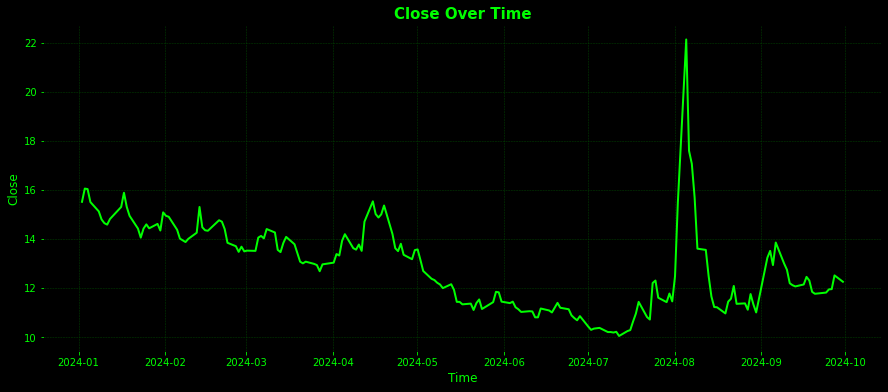

In [3]:
# Import data
data = yahoo.Yahoo()

if HISTORIC_PERIOD != '':
    history_start = (time.now() - timedelta(days=(HISTORIC_PERIOD*365))).strftime('%d/%m/%Y')
else: 
    history_start = (datetime.strptime(START_DATE, '%d/%m/%Y')).strftime('%d/%m/%Y')

# Call data
df = data.get_history(ticker=TICKER, data_interval=INTERVAL, start_date=history_start, end_date=datetime.utcnow().strftime('%d/%m/%Y'))

# Slice df
df.index = pd.to_datetime(df.index,utc=True)
df = df[df.index > history_start]
df = df[~df.index.duplicated(keep='first')]
sample_df = df[[FEATURE]].copy()
sample_df.columns = sample_df.columns.str.lower()

# Plot data
# Create a figure and an axis using subplots
fig, ax = plt.subplots(figsize=(15, 6))

# Set the retro style background color (black) and line color (green)
fig.set_facecolor('black')
ax.set_facecolor('black')  # Set axis background color to black
ax.plot(df[FEATURE], color='#00FF00', linewidth=2)  # Retro terminal green

# Set title, labels, and grid
ax.set_title(f"{FEATURE.capitalize()} Over Time", fontsize=15, color='#00FF00', fontweight='bold')
ax.set_xlabel("Time", fontsize=12, color='#00FF00')
ax.set_ylabel(FEATURE.capitalize(), fontsize=12, color='#00FF00')

# Change x and y ticks color to green
ax.tick_params(axis='x', colors='#00FF00')
ax.tick_params(axis='y', colors='#00FF00')

# Add grid with green lines
ax.grid(color='#004400', linestyle='--', linewidth=0.5)

# Display the plot
plt.show()

___

### STRATEGIES

#### *1. Simple Momentum*

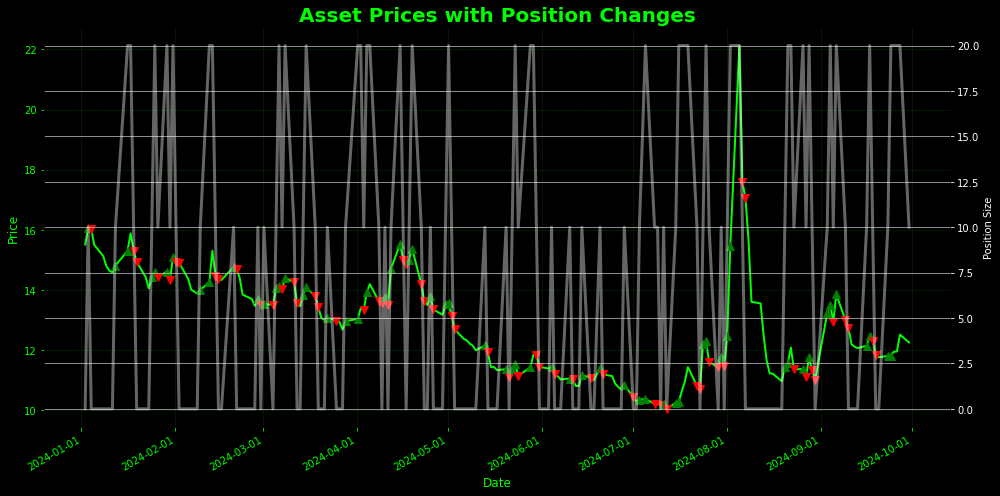

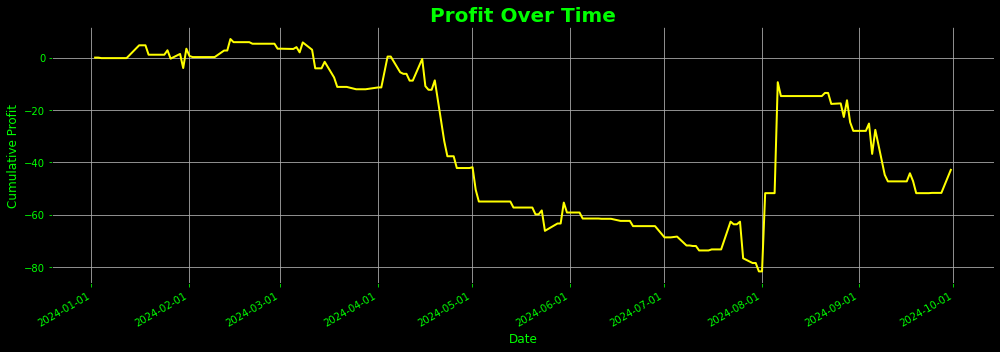

In [7]:
# Get signals and profits from strategy module
sample_df['position_size'] = simple_momentum_vix(df, 100, 1)
profit_df = calculate_profit(sample_df)

# Plot
plot_strategy(sample_df, profit_df)

In [35]:
cap = 3

# Get trades
df['R'] = df['Close'].pct_change()
R = df['R']
signal = np.sign(R.rolling(10, min_periods=10).mean())
final_positions_usd = 10/10 * signal
final_positions_usd = final_positions_usd.fillna(0)

# Pre allocate
total_pos = 0
pos = np.zeros(len(final_positions_usd))

for i, trade in enumerate(final_positions_usd): 
    if abs(total_pos + trade) <= cap: 
        total_pos += trade
    else: 
        None
    pos[i] = total_pos

final_positions_usd.loc[:] = pos

___